In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


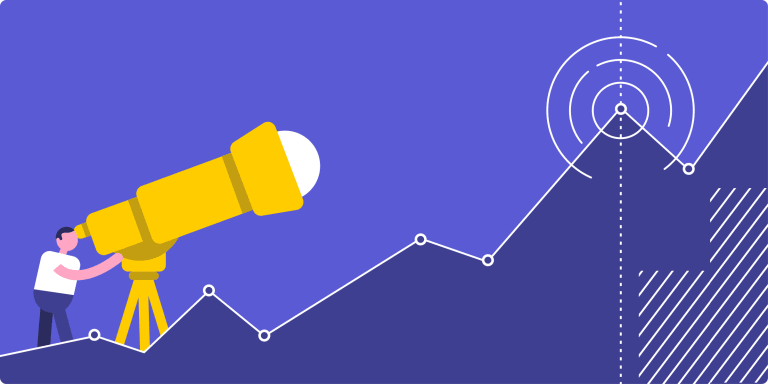

### Types of Time Series Data

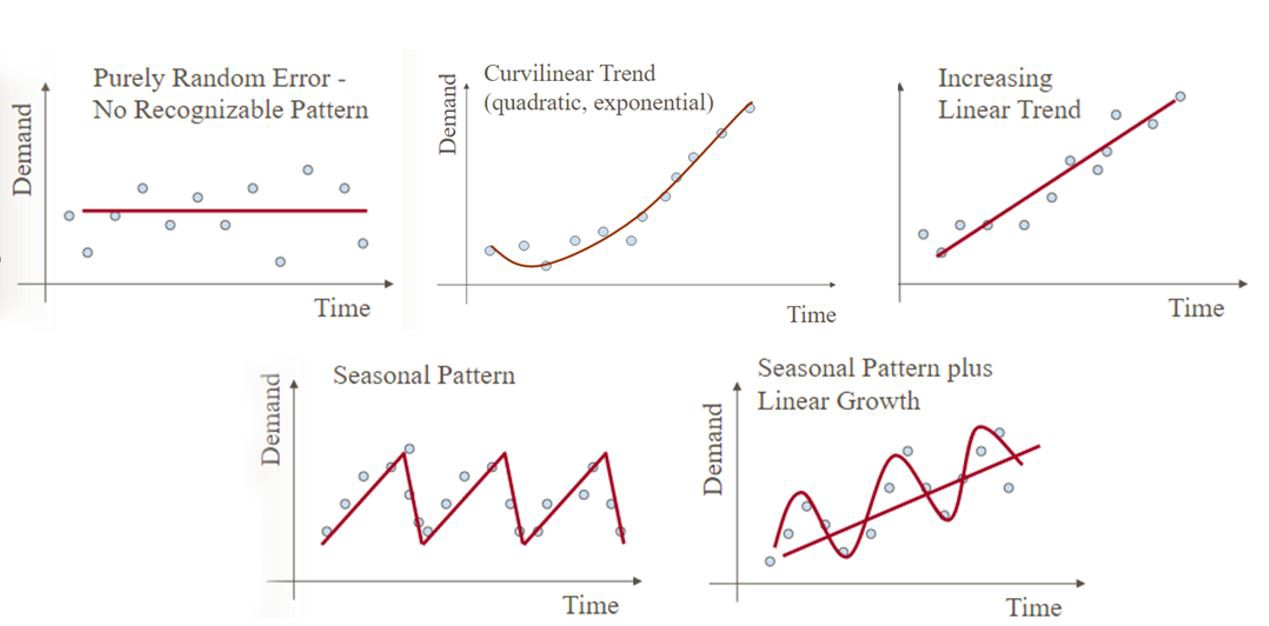

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'PJME Energy Use in MW'}, xlabel='Datetime'>

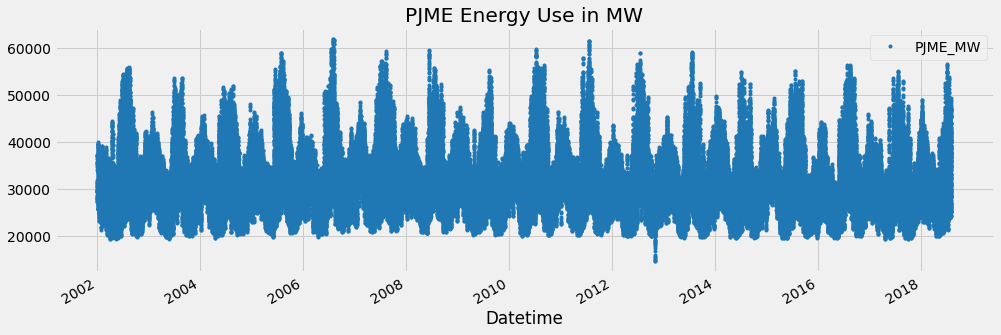

In [4]:
df.plot(style='.', 
        figsize=(15,5), 
        color= color_pal[0], 
        title='PJME Energy Use in MW')

### Train /Test Split

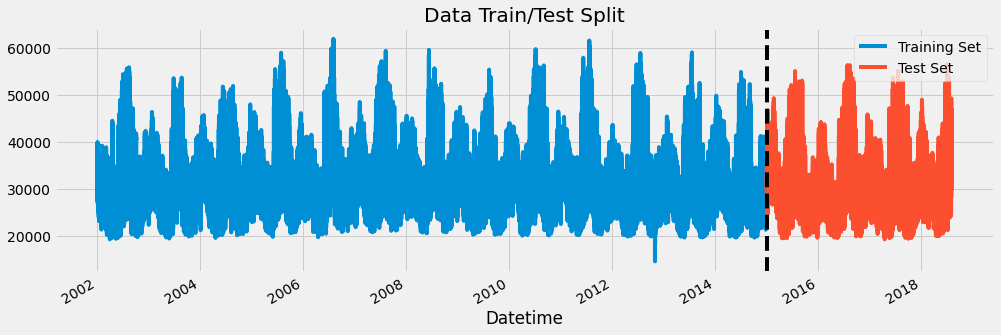

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title= 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot:title={'center':'Week of data'}, xlabel='Datetime'>

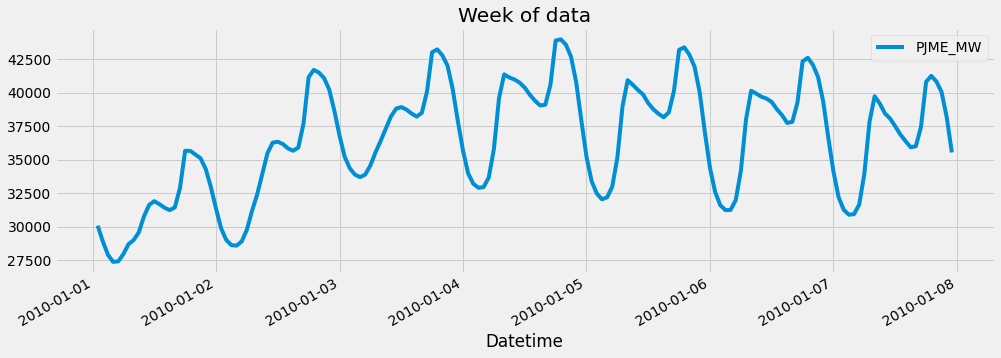

In [6]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),
                                                                  title='Week of data')

### Feature Creation

In [7]:
def create_features(df):    
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week # monday: 0, sunday: 6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [18]:
df = create_features(df)
train = create_features(train)
test = create_features(test)

### Visualize our Feature / Target Relationship

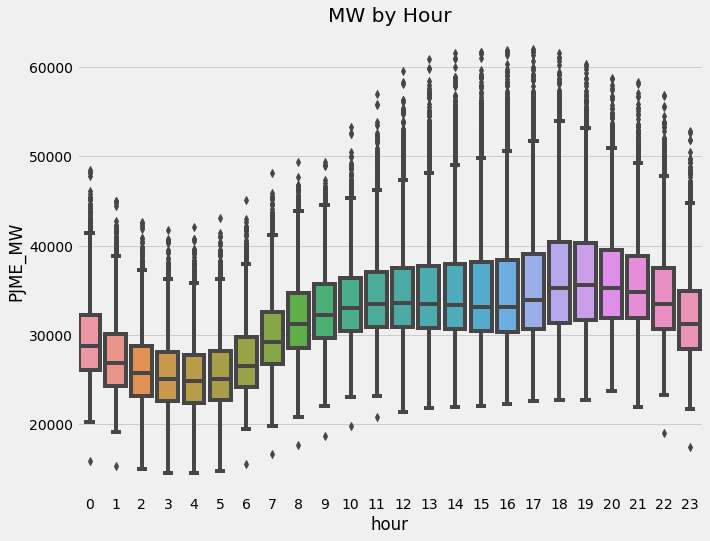

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

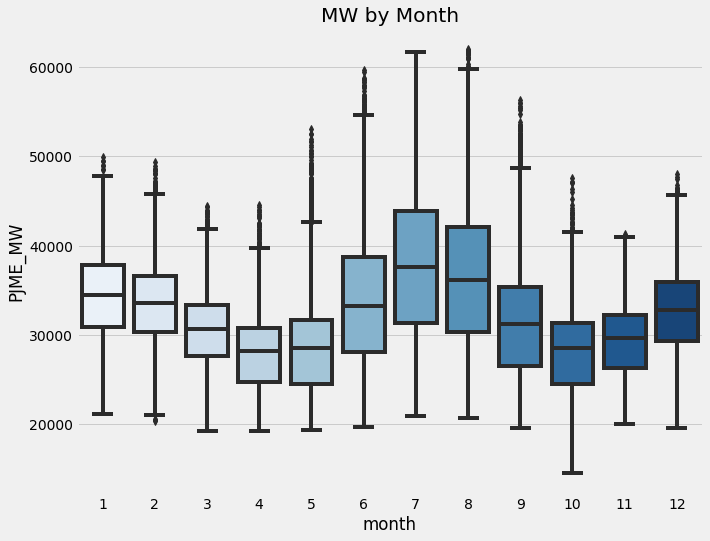

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Create Our Model

In [11]:
# Importing metrics
from sklearn.metrics import mean_squared_error

In [12]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [19]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [20]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds = 50,
                      learning_rate = 0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Feature Importance

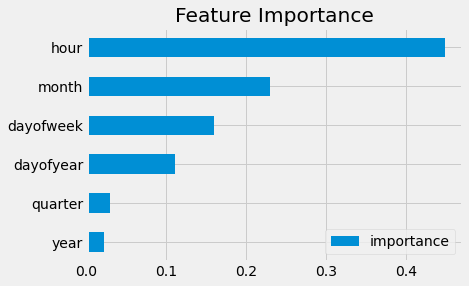

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index = reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on the Test Set

In [23]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True) # merging the dataframes on the index column

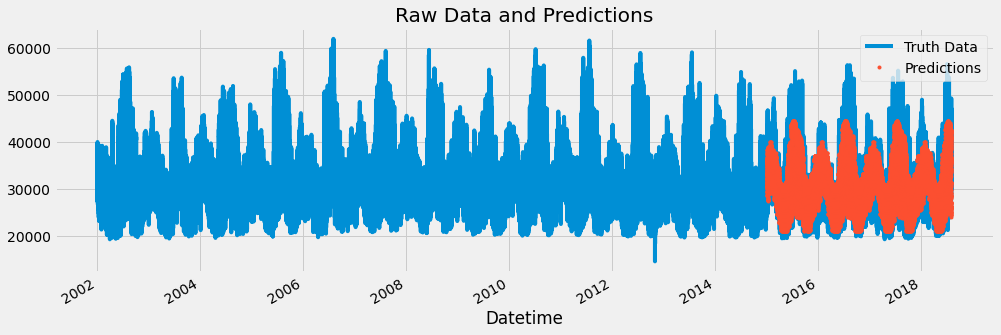

In [24]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,
                     style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

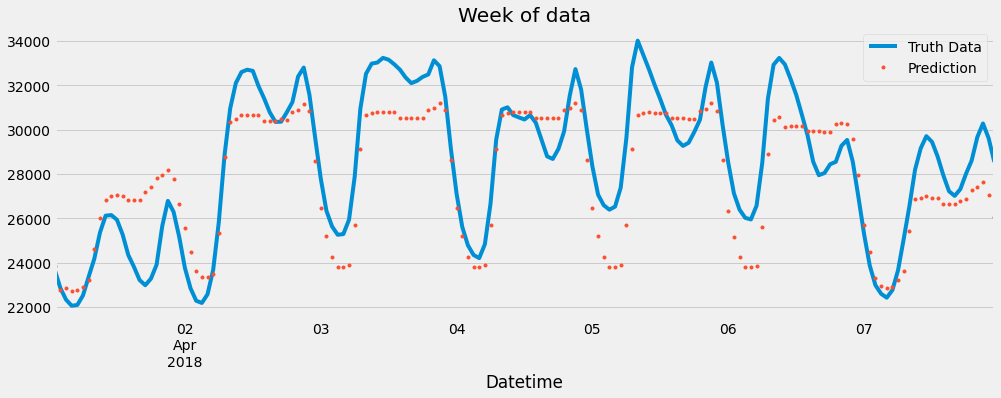

In [25]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5),
                                                                  title='Week of data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [27]:
## Evaluation
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3714.53


### Calculate Error

- Look at the worst and best predicted days

In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [31]:
test['date'] = test.index.date

In [36]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [38]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64

### Next Steps
- Create more robus cross-validation 
- Add more features (weather information, holidays)